## Bicicle algorithm

In [1]:
%load_ext autoreload
%autoreload 2

In [558]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import reservoirpy as rpy
import pickle

from typing import Tuple, List

from src.features.denoise_signal import (
    resample_time_series,
    moving_std_filter,
    holt_winters_filter,
    denoise_signal,
)
from src.features.slice_time_series import create_training_data
from src.models.forecaster import Forecaster
from src import paths

In [3]:
rpy.verbosity(0)

0

In [4]:
signal_df = pd.read_csv(paths.data_processed_dir(
    "test_signal_filtered_dataset_ndvi.csv"), index_col=["ID", "IDpix"])
signal_df.columns = pd.to_datetime(signal_df.columns)
metadata_df = pd.read_csv(paths.data_processed_dir(
    "metadata_filtered_dataset_ndvi.csv"), index_col=["ID", "IDpix"])

In [775]:
metadata_df[metadata_df["label"] == 1]

lat        lon change_type last_non_change_date  \
ID  IDpix                                                          
138 2250  -33.725496 -71.386286     logging           2014-09-11   
    2230  -33.723609 -71.387633     logging           2014-09-11   
89  555   -32.229262 -71.274176     logging           2020-10-06   
128 1450  -33.587514 -71.259623     logging           2019-09-02   
    1441  -33.588323 -71.260432     logging           2019-09-02   
99  878   -34.242386 -71.279027     logging           2018-11-28   
139 2262  -33.754332 -71.469021     logging           2021-05-04   
97  836   -34.241308 -71.281722     logging           2018-11-28   
91  716   -33.907404 -71.378471     logging           2019-12-19   
97  827   -34.241847 -71.281183     logging           2018-11-28   
131 1778  -33.417463 -71.601882     logging           2021-05-25   
85  389   -33.854314 -71.256659     logging           2004-07-03   
131 1723  -33.416924 -71.603768     logging           2021-05-25   
118 1252  -33.545204 -71.390328     logging           2013-05-06   
389 3352  -34.015741 -70.473508        fire           2019-03-14   
372 1216  -34.056165 -71.593527        fire           2016-05-14   
375 1742  -34.519427 -70.981775        fire           2015-01-03   
383 2828  -34.417288 -70.732492        fire           2017-01-03   
389 3444  -34.013855 -70.475664        fire           2019-03-14   
379 2102  -34.708612 -71.329692        fire           2016-12-04   
370 282   -34.515923 -71.774897        fire           2016-05-14   
    307   -34.516193 -71.778131        fire           2016-05-14   
    65    -34.514845 -71.768160        fire           2016-05-14   
391 3875  -33.725765 -71.492736        fire           2021-10-22   
379 2085  -34.708612 -71.331309        fire           2016-12-04   
370 537   -34.515654 -71.768968        fire           2016-05-14   
378 2016  -34.878932 -71.642306        fire           2016-07-26   
391 3868  -33.726574 -71.493814        fire           2021-10-22   
398 4224  -34.880280 -70.902543        fire           2019-02-01   
399 4533  -34.484931 -71.265822        fire           2016-03-18   
372 1298  -34.056435 -71.594605        fire           2016-05-14   
375 1798  -34.518618 -70.980697        fire           2015-01-03   
398 4231  -34.877315 -70.903352        fire           2019-02-01   
370 290   -34.515384 -71.774628        fire           2016-05-14   
378 1914  -34.880819 -71.644462        fire           2016-07-26   
392 3916  -33.754871 -70.593972        fire           2016-05-02   
375 1732  -34.518349 -70.980697        fire           2015-01-03   
371 687   -34.569822 -71.546096        fire           2022-08-02   
393 4029  -34.181480 -71.109784        fire           2022-10-21   
370 14    -34.515923 -71.776245        fire           2016-05-14   
371 956   -34.569014 -71.547174        fire           2022-08-02   

          change_start_date change_ending_date vegetation_type  label  
ID  IDpix                                                              
138 2250         2016-02-23         2016-02-23          native    1.0  
    2230         2016-02-23         2016-02-23          native    1.0  
89  555          2020-12-02         2022-04-24          native    1.0  
128 1450         2019-12-19         2019-12-19          native    1.0  
    1441         2019-12-19         2019-12-19          native    1.0  
99  878          2020-03-09         2020-03-09          native    1.0  
139 2262         2021-10-22         2021-10-22          native    1.0  
97  836          2020-03-09         2020-03-09          native    1.0  
91  716          2020-10-06         2021-01-02          native    1.0  
97  827          2020-03-09         2020-03-09          native    1.0  
131 1778         2021-11-14         2022-04-05          native    1.0  
85  389          2006-04-07         2006-09-16          native    1.0  
131 1723         2021-11-14         2022-04-05          native    1.0  
118 1252    

In [801]:
sel_index = (311, 5656)  # drought
sel_index = (12, 377)  # stable
# sel_index = (379, 2102) # fire
sel_index = (85, 389)  # logging

In [802]:
metadata_df.loc[sel_index]

lat                     -33.854314
lon                     -71.256659
change_type                logging
last_non_change_date    2004-07-03
change_start_date       2006-04-07
change_ending_date      2006-09-16
vegetation_type             native
label                          1.0
Name: (85, 389), dtype: object

## Simulation data structure

In [826]:
from typing import Tuple, List, Dict
import pandas as pd


class PixelSimulation:
    """
    A class to store and manage several simulations of the NDVI dynamics for a single pixel of an image.

    Attributes
    ----------
    index : Tuple[int, int]
        The (row, column) index of the pixel in the image.
    actual_signal : pd.Series
        The actual NDVI signal for the pixel.
    _pred_signal : List[pd.Series]
        A list of predicted NDVI signals for the pixel.
    _date_to_index : Dict[pd.Timestamp, int]
        A mapping from date to the index of the corresponding predicted signal in _pred_signal.
    _index_to_date : Dict[int, pd.Timestamp]
        A mapping from the index of a predicted signal in _pred_signal to its corresponding date.

    Methods
    -------
    __getitem__(index) -> pd.Series
        Returns the predicted signal at the specified index.
    __iter__() -> 'PixelSimulation'
        Initializes the iterator and returns the iterator object.
    __next__() -> pd.Series
        Returns the next predicted signal in the iteration.
    __len__() -> int
        Returns the number of predicted signals.
    append(pred: pd.Series) -> None
        Appends a predicted signal to the list of predicted signals.
    get_pred_from_date(date: pd.Timestamp) -> pd.Series
        Returns the predicted signal for a specified date.
    get_date_from_pred(index: int) -> pd.Timestamp
        Returns the date for a specified predicted signal index.
    """

    def __init__(self, index: Tuple[int, int], actual_signal: pd.Series):
        self.index = index
        self.actual_signal = actual_signal
        self._pred_signal = []
        self._date_to_index = {}
        self._index_to_date = {}
        self.__index = 0  # for iteration

    def __getitem__(self, index) -> pd.Series:
        try:
            return self._pred_signal[index]
        except IndexError:
            raise IndexError("Index out of range.")

    def __iter__(self):
        self.__index = 0
        return self

    def __next__(self) -> pd.Series:
        if self.__index < len(self._pred_signal):
            result = self._pred_signal[self.__index]
            self.__index += 1
            return result
        else:
            raise StopIteration

    def __len__(self) -> int:
        return len(self._pred_signal)

    def append(self, pred: pd.Series) -> None:
        date = pred.index[0]
        index = len(self._pred_signal)

        self._date_to_index[date] = index
        self._index_to_date[index] = date

        self._pred_signal.append(pred)

    def get_pred_from_date(self, date: pd.Timestamp) -> pd.Series:
        try:
            index = self._date_to_index[date]
            return self._pred_signal[index]
        except KeyError:
            raise KeyError(f"No prediction found for date {date}.")

    def get_date_from_pred(self, index: int) -> pd.Timestamp:
        try:
            date = self._index_to_date[index]
            return date
        except KeyError:
            raise KeyError(f"No date found for index {index}.")

## Simulation algorithm

In [821]:
with open(paths.models_dir("trained_esn_ndvi.pickle"), "rb") as file:
    model = pickle.load(file)

signal: pd.Series = signal_df.loc[sel_index]
model: rpy.model.Model = model
num_features: int = 104
forecasted_steps: int = 52
step_size: int = 1

# TODO: Do we need to keep start and end dates for denoised signal?

denoised_signal_series = denoise_signal(
    signal, [
        resample_time_series,
        moving_std_filter,
        holt_winters_filter,
    ]
)

denoised_signal_dates = denoised_signal_series.index.to_numpy()
denoised_signal_dates = denoised_signal_dates.reshape(-1, 1)
X_dates = denoised_signal_dates[num_features:, :]

denoised_signal = denoised_signal_series.to_numpy()
X, _ = create_training_data(denoised_signal, num_features=num_features)


signal_forecaster = Forecaster(model, num_features=num_features)

num_forecasts = X.shape[0] - forecasted_steps

pixel_simulation = PixelSimulation(index=signal.name,
                                   actual_signal=denoised_signal_series)

for i in range(num_forecasts):

    warmup = X[i:i + num_features, :]

    pred_signal = signal_forecaster.forecast(
        prediction_length=forecasted_steps,
        warmup_X=warmup,
    )
    pred_dates = X_dates[i: i + forecasted_steps, :]

    pred_series = pd.Series(pred_signal.flatten(), index=pred_dates.flatten())
    pred_starting_date = pred_series.index[0]

    pixel_simulation.append(pred_series)

In [825]:
# Packed function

import pickle
import pandas as pd
import copy
from typing import Tuple, List
from concurrent.futures import ProcessPoolExecutor
from src.features.denoise_signal import (
    resample_time_series,
    moving_std_filter,
    holt_winters_filter,
    denoise_signal,
)


def forecast_pixel_ndvi(
    model: object,
    signal: pd.Series,
    num_features: int = 104,
    forecasted_steps: int = 52,
) -> PixelSimulation:
    """
    Forecasts the NDVI dynamics for a single pixel using a trained model.
    """

    # Denoise the signal
    denoised_signal_series = denoise_signal(
        signal, [
            resample_time_series,
            moving_std_filter,
            holt_winters_filter,
        ]
    )

    denoised_signal_dates = denoised_signal_series.index.to_numpy().reshape(-1, 1)
    X_dates = denoised_signal_dates[num_features:, :]

    denoised_signal = denoised_signal_series.to_numpy()
    X, _ = create_training_data(denoised_signal, num_features=num_features)

    signal_forecaster = Forecaster(model, num_features=num_features)
    num_forecasts = X.shape[0] - forecasted_steps

    pixel_simulation = PixelSimulation(
        index=signal.name, actual_signal=denoised_signal_series)

    for i in range(num_forecasts):
        warmup = X[i:i + num_features, :]

        pred_signal = signal_forecaster.forecast(
            prediction_length=forecasted_steps,
            warmup_X=warmup,
        )
        pred_dates = X_dates[i: i + forecasted_steps, :]

        pred_series = pd.Series(pred_signal.flatten(),
                                index=pred_dates.flatten())
        pixel_simulation.append(pred_series)

    return pixel_simulation


def process_pixel(args):
    model, signal_df, sel_index, num_features, forecasted_steps, step_size = args
    signal = signal_df.loc[sel_index]
    return forecast_pixel_ndvi(model, signal, num_features, forecasted_steps, step_size)


def parallel_process_pixels(
    model_path: str,
    signal_df: pd.DataFrame,
    pixel_indices: List[Tuple[int, int]],
    num_features: int = 104,
    forecasted_steps: int = 52,
    num_processes: int = 4
) -> List[PixelSimulation]:
    """
    Parallel process each pixel for NDVI forecasting using a pool of workers.

    Parameters
    ----------
    model_path : str
        Path to the pretrained model pickle file.
    signal_df : pd.DataFrame
        DataFrame containing the NDVI signals.
    pixel_indices : List[Tuple[int, int]]
        List of pixel indices to process.
    num_features : int, optional
        Number of features used for training, by default 104.
    forecasted_steps : int, optional
        Number of steps to forecast, by default 52.
    step_size : int, optional
        Step size for the forecast, by default 1.
    num_processes : int, optional
        Number of parallel processes, by default 4.

    Returns
    -------
    List[PixelSimulation]
        List of PixelSimulation objects for each pixel.
    """

    # Load the pretrained model once
    with open(model_path, "rb") as file:
        pretrained_model = pickle.load(file)

    # Create an argument list for each pixel, copying the pretrained model
    args_list = [(copy.deepcopy(pretrained_model), signal_df, idx,
                  num_features, forecasted_steps) for idx in pixel_indices]

    results = []
    with ProcessPoolExecutor(max_workers=num_processes) as executor:
        futures = [executor.submit(process_pixel, args) for args in args_list]
        for future in futures:
            results.append(future.result())

    return results

In [827]:
pixel_indices = signal_df.index

results = parallel_process_pixels(
    model_path=paths.models_dir("trained_esn_ndvi.pickle"),
    signal_df=signal_df,
    pixel_indices=pixel_indices,
    num_features=104,
    forecasted_steps=52,
    num_processes=4
)

## Index results as a dataframe

In [ ]:
# TODO

## Detection algorithm

In [822]:
N = 10
k = 0.8
offset = 1

detected_dates = []


num_of_detections = (len(pixel_simulation) - 1) - offset
num_of_windows = forecasted_steps - offset

for i in range(num_of_detections):
    for j in range(num_of_windows):
        detection_window = pixel_simulation[i + offset].iloc[j:j+N].to_numpy(
        ) < k * pixel_simulation[i].iloc[j: j + N].to_numpy()
        flag = np.all(detection_window)

        if flag:
            detected_dates.append(pixel_simulation[i].index[0])
            break

In [ ]:
# Packed function

import numpy as np
import pandas as pd
from typing import List


def detect_changes_in_pixel(
    pixel_simulation: PixelSimulation,
    N: int = 10,
    k: float = 0.8,
    offset: int = 1,
    forecasted_steps: int = 52
) -> List[pd.Timestamp]:
    """
    Detects changes in a pixel simulation by comparing forecasted values with actual values.

    Parameters
    ----------
    pixel_simulation : PixelSimulation
        The PixelSimulation object containing the actual and predicted NDVI signals.
    N : int, optional
        The length of the detection window, by default 10.
    k : float, optional
        The threshold factor for detecting significant changes, by default 0.8.
    offset : int, optional
        The offset between the actual signal and the predicted signal to compare, by default 1.
    forecasted_steps : int, optional
        The number of steps in each forecast, by default 52.

    Returns
    -------
    List[pd.Timestamp]
        A list of timestamps where significant changes are detected.
    """
    detected_dates = []
    num_of_detections = (len(pixel_simulation) - 1) - offset
    num_of_windows = forecasted_steps - offset

    for i in range(num_of_detections):
        for j in range(num_of_windows):
            detection_window = pixel_simulation[i + offset].iloc[j:j + N].to_numpy(
            ) < k * pixel_simulation[i].iloc[j: j + N].to_numpy()
            flag = np.all(detection_window)

            if flag:
                detected_dates.append(pixel_simulation[i].index[0])
                break

    return detected_dates

# Example usage
# detected_dates = detect_changes_in_pixel(pixel_simulation, N=10, k=0.8, offset=1, forecasted_steps=52)

In [816]:
lower_bound_detection_date = pd.Timestamp(
    metadata_df.loc[sel_index]["last_non_change_date"])
upper_bound_detection_date = pd.Timestamp(
    metadata_df.loc[sel_index]["change_ending_date"])

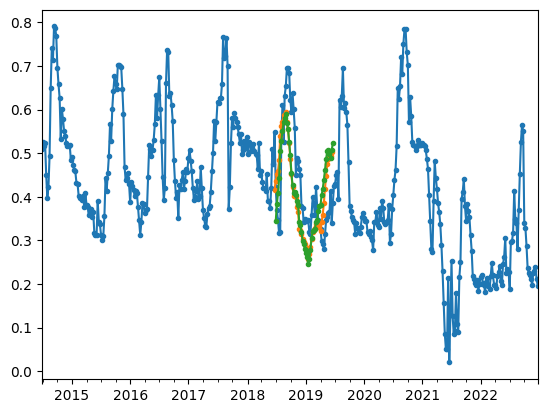

In [824]:
starting_date = pd.Timestamp("2021-11-14") + pd.Timedelta(weeks=0)

offset = 1
start_week = 104

# Plotting the actual signal with smaller dots
pixel_simulation.actual_signal.plot(marker='o', markersize=3)

# Plotting the predictions with smaller dots
pixel_simulation[start_week].plot(marker='o', markersize=3)
pixel_simulation[start_week + offset].plot(marker='o', markersize=3)

# plt.ylim(-1, 1)
plt.show()

## Change detection protocols

In [547]:
# TODO: How can I use the prediction object to detect faults?